In [27]:
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import stateinterpreter
from stateinterpreter.MD import Loader
from stateinterpreter.classifier import Classifier
from stateinterpreter.plot import plot_cvpath, plot_states, plot_combination_cvs_relevant_features
from importlib import reload
reload(stateinterpreter.classifier)

<module 'stateinterpreter.classifier' from '../../stateinterpreter/classifier.py'>

In [2]:
import re
def get_residue(s):
    m = re.search(r'\d+$', s)
    return m.group() if m else None

def _get_angle_groups(angle_names):
    groups = []
    for s in angle_names:
        groups.append(get_residue(s))
    return np.array(groups, dtype=int)

In [47]:
BPTI_data_path = '../../../data/md_datasets/BPTI-unbiased/'
colvar_file = BPTI_data_path + 'COLVAR'
traj_dict = {
        'trajectory' : BPTI_data_path+'all_trj_10ns.trr',
        'topology' : BPTI_data_path+'bpti-protein.pdb'
    }
desc_path = '../../../data/md_datasets/BPTI-unbiased/descritpors.pkl'
descriptors = pd.read_pickle(desc_path)
# Compute descriptors from Trajectory
data = Loader(colvar_file, descriptors=descriptors, kbt=2.5)
data.load_trajectory(traj_dict, descriptors=False)

KeyError: 'Basins not selected. Call identify_states() first.'

In [48]:
cv_list = ['tica1', 'tica2']
bounds = [(-1,1), (-1,1)]
data.identify_states(cv_list, bounds, bw_method=0.3, fes_cutoff=2.5)
df = data.collect_data()

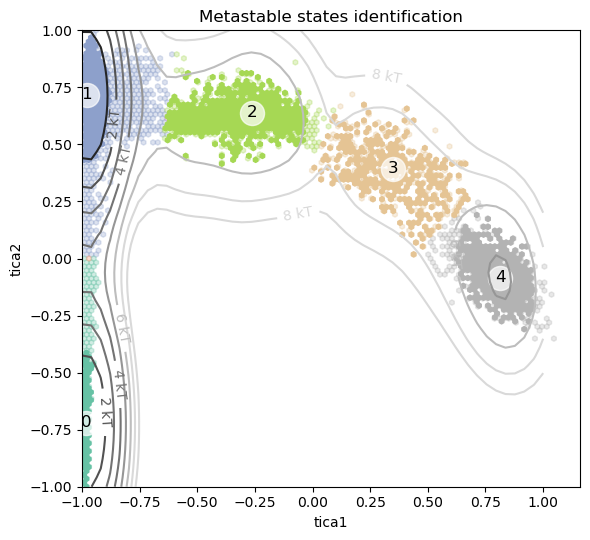

In [5]:
plot_states(data, fes_isolines=True)

In [6]:
for idx in range(data.n_basins):
    l = len(data.basins.loc[ (data.basins['basin'] == idx) & (data.basins['selection'] == True)])
    print(f"{idx} -> {l}")

0 -> 26227
1 -> 71427
2 -> 1228
3 -> 416
4 -> 861


In [7]:
select_feat = 'sin_|cos_'
sample = data.sample(400, regex_filter = select_feat)

In [28]:
groups = _get_angle_groups(sample.features)
regularizers = np.geomspace(0.1, 1, 12)
dset = sample.train_test_dataset()
classifier = Classifier(dset, sample.features)
classifier.compute(regularizers, max_iter= 100000, groups=groups)

Group Lasso: 100%|██████████| 12/12 [00:28<00:00,  2.38s/it]


(-1.0, 0.0)

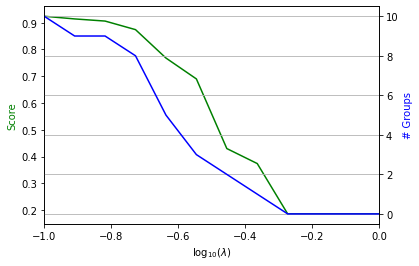

In [29]:
num_groups = []
for reg in regularizers:
    selected = classifier._get_selected(reg)
    unique_idxs = set()
    for state in selected:
        for data in state:
            unique_idxs.add(data[0])
    num_groups.append(len(unique_idxs))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.grid()
ax2.plot(np.log10(regularizers), num_groups, 'b-')
ax1.plot(np.log10(regularizers), classifier._crossval, 'g-')
#ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

ax1.set_xlabel(r"$\log_{10}(\lambda)$")
ax1.set_ylabel('Score', color='g')
ax2.set_ylabel('# Groups', color='b')
ax1.set_xlim(np.log10(regularizers)[0],np.log10(regularizers)[-1])

State 0:
	 42.725% | 38
	 31.269% | 42
	 6.893%  | 39
	 6.551%  | 36
	 4.715%  | 10
	 3.317%  | 14
	 2.334%  | 9
	 1.541%  | 35
	 0.584%  | 6
	 0.07%   | 15
State 1:
	 66.874% | 42
	 9.699%  | 38
	 8.128%  | 39
	 6.51%   | 36
	 3.523%  | 14
	 2.528%  | 6
	 1.228%  | 10
	 0.814%  | 9
	 0.626%  | 35
	 0.071%  | 15
State 2:
	 26.395% | 42
	 26.212% | 36
	 20.827% | 9
	 7.405%  | 10
	 6.586%  | 14
	 6.113%  | 6
	 4.533%  | 38
	 1.247%  | 39
	 0.603%  | 35
	 0.08%   | 15
State 3:
	 40.101% | 42
	 24.515% | 36
	 12.742% | 9
	 7.765%  | 6
	 4.243%  | 38
	 4.19%   | 10
	 2.707%  | 39
	 2.158%  | 35
	 1.528%  | 14
	 0.05%   | 15
State 4:
	 34.876% | 36
	 24.656% | 42
	 11.278% | 38
	 10.433% | 14
	 4.768%  | 9
	 3.812%  | 6
	 3.694%  | 39
	 3.692%  | 10
	 2.622%  | 35
	 0.169%  | 15


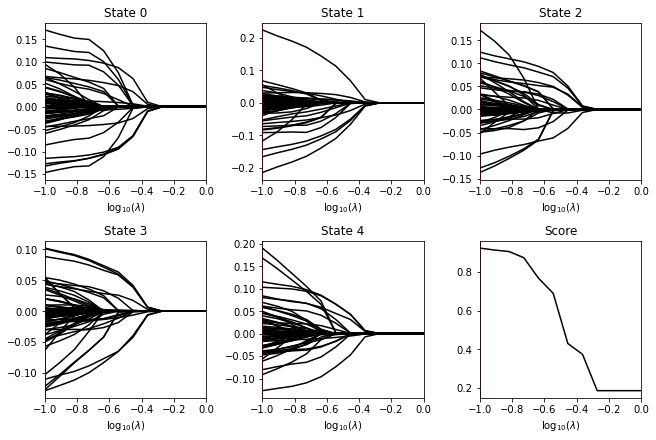

In [30]:
reg = 10**(-1)
plot_cvpath(classifier, reg);
classifier.print_selected(reg)

In [38]:
regularizers = np.geomspace(0.1, 1, 12)
pruned_classifier = classifier.get_pruned(reg)
pruned_classifier.compute(regularizers, max_iter= 10000, quadratic_kernel=False)

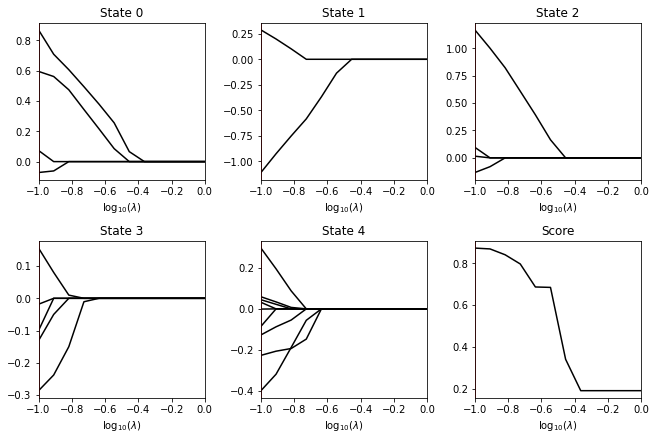

In [39]:
plot_cvpath(pruned_classifier, reg);

In [43]:
extrapruned_classifier = pruned_classifier.get_pruned(reg)
extrapruned_classifier.compute(regularizers, max_iter= 10000, quadratic_kernel=True)

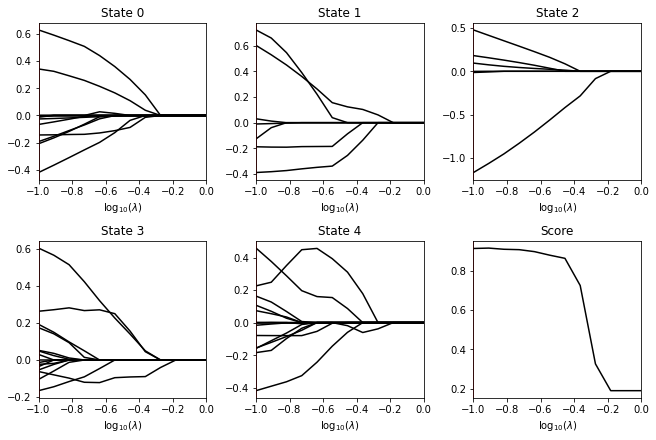

In [44]:
plot_cvpath(extrapruned_classifier, reg);

In [45]:
reg = 10**(-0.5)
extrapruned_classifier.print_selected(reg)

State 0:
	 69.73%  | BACKBONE sin_phi CYS38
	 14.88%  | BACKBONE cos_phi ARG39 || BACKBONE cos_psi ARG42
	 8.553%  | BACKBONE sin_phi GLY36 || BACKBONE cos_psi GLY36
	 6.69%   | SIDECHAIN sin_chi1 TYR10 || SIDECHAIN sin_chi1 TYR10
	 0.134%  | BACKBONE cos_psi ARG39
	 0.012%  | BACKBONE cos_psi TYR35 || BACKBONE cos_psi TYR35
State 1:
	 65.582% | BACKBONE sin_phi GLY36 || BACKBONE cos_psi GLY36
	 19.592% | BACKBONE cos_phi ARG39
	 13.944% | BACKBONE sin_phi CYS38 || BACKBONE cos_psi CYS38
	 0.881%  | BACKBONE cos_psi ARG42
State 2:
	 91.958% | BACKBONE cos_psi LEU6 || BACKBONE cos_psi ARG42
	 7.527%  | BACKBONE cos_psi PRO9
	 0.358%  | BACKBONE cos_psi TYR10 || BACKBONE cos_psi TYR10
	 0.157%  | BACKBONE cos_phi CYS38 || BACKBONE cos_psi CYS38
State 3:
	 50.858% | BACKBONE sin_phi ARG42 || BACKBONE cos_psi ARG42
	 41.717% | BACKBONE cos_psi PRO9 || BACKBONE cos_psi GLY36
	 7.425%  | BACKBONE sin_phi CYS38 || BACKBONE cos_psi ARG39
	 0.0%    | BACKBONE cos_phi ARG39 || BACKBONE cos_phi A

In [50]:
plot_combination_cvs_relevant_features(df, cv_list, extrapruned_classifier._get_selected(reg))

AttributeError: 'list' object has no attribute 'values'